In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [2]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [3]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [4]:
from collections import OrderedDict

# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [.01],
    batch_size = [100],
    shuffle = [False]
)
epochs = 10

In [5]:
# import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

In [6]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [7]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = Network()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0]
        labels = batch[1]
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.570251,0.782467,14.495408,14.870733,0.01,100,False
1,1,2,0.394129,0.854683,15.337314,30.430038,0.01,100,False
2,1,3,0.365927,0.863783,17.402673,48.006067,0.01,100,False
3,1,4,0.350906,0.870200,15.457454,63.669652,0.01,100,False
4,1,5,0.340356,0.873483,17.086275,80.923081,0.01,100,False
5,1,6,0.334969,0.874950,16.784398,97.895981,0.01,100,False
6,1,7,0.330702,0.875617,14.898685,113.004247,0.01,100,False
7,1,8,0.324146,0.878717,14.329381,127.542439,0.01,100,False
8,1,9,0.326355,0.879267,16.417314,144.134462,0.01,100,False
9,1,10,0.320547,0.881867,20.090407,164.435451,0.01,100,False


In [8]:
def get_pil_transform(): 
    transf = transforms.Compose([
        #transforms.Resize((28, 28)),
    ])    

    return transf

def get_preprocess_transform():
    transf = transforms.Compose([
        #transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [9]:
def batch_predict(pred_images):
    pred_images = pred_images[:,:,:,0]
    batchy = torch.stack(tuple(preprocess_transform(i) for i in pred_images), dim=0)
    
    logits = network(batchy)
    probs = F.softmax(logits, dim=1)
    return probs.detach().numpy()

In [10]:
def batch_true_predict(pred_images):
    batchy = torch.stack(tuple(preprocess_transform(i) for i in pred_images), dim=0)
    
    logits = network(batchy)
    probs = F.softmax(logits, dim=1)
    return probs.detach().numpy()

In [11]:
test_dataloader      = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)
imgs, lbls  = iter(test_dataloader).next()

img = torchvision.transforms.ToPILImage()(imgs[0])

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(img)
print(lbls[0])

tensor(9)


In [13]:
img

In [14]:
pix = np.array(img)
pix.shape

(28, 28)

In [15]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(pix, 
                                         batch_predict, # classification function
                                         #top_labels=5, 
                                         hide_color=0, 
                                         num_samples=10000) # number of images that will be sent to classification function

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
explanation.local_exp

{4: [(0, -0.00012414659582286574)],
 8: [(0, -0.04177399202316963)],
 5: [(0, -0.5016556347914533)],
 7: [(0, -0.05404926902478154)],
 9: [(0, 0.6107890206306894)]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


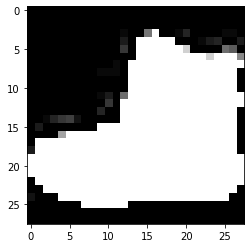

In [17]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/28, mask)
plt.imshow(img_boundry1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


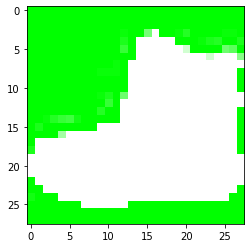

In [357]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/28, mask)
plt.imshow(img_boundry2)

In [313]:
sample_size = 1000
sample_lbls = []
sample_imgs = []

iterator = iter(torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0))

for i in range(samp_size):
    img, lbl  = next(iterator)
    img = torchvision.transforms.ToPILImage()(img[0])
    sample_lbls.append(lbl)
    sample_imgs.append(img)

In [314]:
img

In [316]:
true_preds = batch_true_predict(sample_imgs)

In [ ]:
from tqdm import tqdm

lime_local_pred = []
lime_local_exp = []
lime_score = []
for im in tqdm(sample_imgs):
    exp = explainer.explain_instance(np.array(im), batch_predict)
    lime_local_pred.append(exp.local_pred)
    lime_local_exp.append(exp.local_exp)
    lime_score.append(exp.score)


In [338]:
lime_local_pred = np.stack(lime_local_pred)

In [333]:
top_lime_preds = []
for mas in lime_local_pred:
    top_lime_preds.append(mas[0])

In [334]:
top_lime_preds

[0.999242292718836,
 0.999705594429326,
 0.760479392137781,
 0.8510977746392924,
 0.8032226943687121,
 0.9991835959694996,
 0.9996766330713784,
 0.924037754275223,
 0.9996955101811675,
 0.9997230389409515,
 0.9895837577910864,
 0.9996343080380617,
 0.9997255884919062,
 0.5194246074173241,
 0.9959958575866932,
 0.9997191541565544,
 0.9997544481753237,
 0.9721875364663721,
 0.6326634884973502,
 0.4989556261856058,
 0.9995595457735245,
 0.9997406955413086,
 0.9786720186778403,
 0.9998699598103774,
 0.5984698894041992,
 0.9345702688880323,
 0.999502467122179,
 0.9567504944400176,
 0.608128799719257,
 0.7579560453267337,
 0.9997134267879084,
 0.9915327395212402,
 0.5182112982966988,
 0.9713147000698662,
 0.9926511883133249,
 1.000000000058886,
 0.9997122093961425,
 0.987551312362964,
 1.0,
 0.7629994547590857,
 0.9102319746428792,
 0.945831254291514,
 0.9997318432406345,
 0.9996173430444817,
 0.9992315837481878,
 0.6554703355595488,
 0.9961184117533802,
 0.999301390461896,
 0.99948745968989

In [329]:
top_true_preds = []
for mas in true_preds:
    top_true_preds.append(mas.max())

In [330]:
top_true_preds

[0.9995266,
 0.99999714,
 0.7607055,
 0.85131276,
 0.80341846,
 0.99943227,
 0.9998832,
 0.9240701,
 1.0,
 1.0,
 0.98986316,
 0.99993956,
 0.99999297,
 0.52388567,
 0.99996245,
 0.9999994,
 1.0,
 0.97244316,
 0.63281614,
 0.49909303,
 0.9998406,
 1.0,
 0.97894704,
 0.99999785,
 0.59863436,
 0.9348349,
 0.9997695,
 0.95699644,
 0.6083027,
 0.7581589,
 0.9999993,
 0.9954717,
 0.51834244,
 0.9715763,
 0.99292964,
 1.0,
 0.9999981,
 0.9878177,
 1.0,
 0.76320195,
 0.91050607,
 0.9460912,
 0.9999999,
 0.99987686,
 0.9995264,
 0.6556435,
 0.9999746,
 0.9995454,
 0.99976355,
 0.99864787,
 0.9999939,
 0.9998851,
 1.0,
 0.85107577,
 0.67972374,
 0.8269429,
 0.7811845,
 0.99993825,
 0.9979285,
 0.98943555,
 1.0,
 0.8285379,
 1.0,
 0.9999465,
 0.9629029,
 0.95493126,
 0.99896836,
 0.8440405,
 0.79829305,
 1.0,
 0.7318693,
 1.0,
 0.71324074,
 0.9972651,
 1.0,
 0.9472802,
 0.6198413,
 0.5090514,
 1.0,
 0.99193734,
 1.0,
 0.991999,
 0.9999989,
 0.99016225,
 0.9999651,
 0.9974064,
 1.0,
 0.9994593,
 0

In [362]:
true_lime = []
for i in range(sample_size):
    true_lime.append((top_true_preds[i], top_lime_preds[i]))

In [368]:
true_lime.sort(key=lambda x: -x[0])

In [369]:
true_lime

[(1.0, 0.9996955101811675),
 (1.0, 0.9997230389409515),
 (1.0, 0.9997544481753237),
 (1.0, 0.9997406955413086),
 (1.0, 1.000000000058886),
 (1.0, 1.0),
 (1.0, 0.9959188366539629),
 (1.0, 0.9997080790148929),
 (1.0, 0.9997296239009297),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 0.9963129753117295),
 (1.0, 0.9965271428812602),
 (1.0, 0.9965265603634847),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 0.999742824654771),
 (1.0, 0.9998486839138601),
 (1.0, 0.9998437939489542),
 (1.0, 0.9963079028595724),
 (1.0, 0.9966980275982037),
 (1.0, 0.9998503862421142),
 (1.0, 0.9963837774102606),
 (1.0, 0.999894970295015),
 (1.0, 0.9998521429166444),
 (1.0, 0.999734599442117),
 (1.0, 0.9997245576242704),
 (1.0, 0.9997047875304544),
 (1.0, 0.9957023788223609),
 (1.0, 1.0),
 (1.0, 0.99974595088758),
 (1.0, 0.9998712851536642),
 (1.0, 0.9965002393299973),
 (1.0, 0.9998858753828392),
 (1.0, 0.9997308039823409),
 (1.0, 0.9998870581145229),
 (1.0, 0.9998499358350371),
 (1.0, 1.0),
 (1.0, 0.9963661105807909),
 (1.0, 0.9997162559

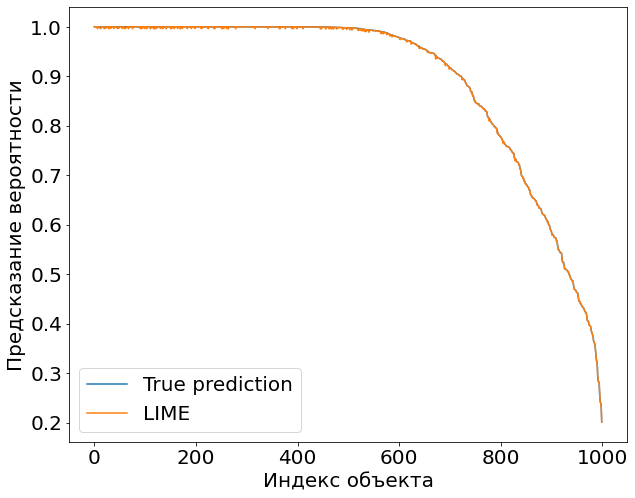

In [382]:
plt.rcParams['font.size'] = '20'

li = [true_lime[i][1] for i in range(sample_size)]
tr = [true_lime[i][0] for i in range(sample_size)]
fig = plt.figure(figsize=(10, 8))
plt.plot(tr, label='True prediction')
plt.plot(li, label='LIME')
plt.xlabel('Индекс объекта', fontsize=20)
plt.ylabel('Предсказание вероятности', fontsize=20)
plt.legend(loc=3)
fig.axes[0].set_rasterized(True)
plt.show()